# Run scMODAL on the CITE-seq PBMC dataset

In this tutorial, we show how to run scMODAL integration of the CITE-seq PMBC data. The raw dataset is available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE164378. Preprocessed data can be found here: https://drive.google.com/drive/folders/16MyDgz3iLKonZmshiU8YJxnBJw6UrGOx?usp=sharing.

## Import packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import os

import scmodal

import warnings
warnings.filterwarnings("ignore")

## Preprocessing

### Load data

In [2]:
adata_RNA = sc.read_h5ad('./data/citeseq_pbmc/multi.h5ad')
adata_RNA.var.index = adata_RNA.var['_index']
adata_RNA.X = adata_RNA.raw.X.toarray()

counts_ADT = pd.read_csv('./data/citeseq_pbmc/ADT.csv').T
adata_ADT = ad.AnnData(X = counts_ADT.values)
adata_ADT.obs.index = counts_ADT.index
adata_ADT.var.index = counts_ADT.columns
adata_ADT.obs = adata_RNA.obs.loc[adata_ADT.obs.index]
adata_RNA = adata_RNA[adata_RNA.obs.donor == 'P1']
adata_ADT = adata_ADT[adata_RNA.obs.index]
adata_RNA = adata_RNA[adata_RNA.obs['celltype.l2'].values != 'Doublet']
adata_ADT = adata_ADT[adata_ADT.obs['celltype.l2'].values != 'Doublet']

### Identify shared and unique features

Match proteins and their coding gene names.
Code and conversion file are copied and modified based on MaxFuse https://github.com/shuxiaoc/maxfuse/tree/main.

In [3]:
correspondence = pd.read_csv('./protein_gene_conversion.csv')
correspondence['Protein name'] = correspondence['Protein name'].replace(to_replace={'CD11a-CD18': 'CD11a/CD18', 'CD66a-c-e': 'CD66a/c/e'})
print(correspondence)

rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in adata_ADT.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in adata_RNA.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

    Protein name  RNA name
0           CD80      CD80
1           CD86      CD86
2          CD274     CD274
3          CD273  PDCD1LG2
4          CD275    ICOSLG
..           ...       ...
347       Nestin       NES
348   aDefensin5     DEFA5
349          p63      TP63
350         MUC6      MUC6
351          IDO      IDO1

[352 rows x 2 columns]


In [4]:
RNA_shared = adata_RNA[:, rna_protein_correspondence[:, 0]].copy()
ADT_shared = adata_ADT[:, rna_protein_correspondence[:, 1]].copy()
RNA_shared.var['feature_name'] = RNA_shared.var.index.values
ADT_shared.var['feature_name'] = ADT_shared.var.index.values
RNA_shared.var_names_make_unique()
ADT_shared.var_names_make_unique()

In [5]:
RNA_unshared = adata_RNA[:, sorted(set(adata_RNA.var.index) - set(rna_protein_correspondence[:, 0]))].copy()
ADT_unshared = adata_ADT[:, sorted(set(adata_ADT.var.index) - set(rna_protein_correspondence[:, 1]))].copy()

sc.pp.highly_variable_genes(RNA_unshared, flavor='seurat_v3', n_top_genes=3000)
RNA_unshared = RNA_unshared[:, RNA_unshared.var.highly_variable].copy()

RNA_unshared.var['feature_name'] = RNA_unshared.var.index.values
ADT_unshared.var['feature_name'] = ADT_unshared.var.index.values

### Normalization

In [6]:
RNA_counts = RNA_shared.X.sum(axis=1)
ADT_counts = ADT_shared.X.sum(axis=1)
target_sum = np.maximum(np.median(RNA_counts.copy()), 20)

sc.pp.normalize_total(RNA_shared, target_sum=target_sum)
sc.pp.log1p(RNA_shared)

sc.pp.normalize_total(ADT_shared, target_sum=target_sum)
sc.pp.log1p(ADT_shared)

sc.pp.normalize_total(RNA_unshared)
sc.pp.log1p(RNA_unshared)

sc.pp.normalize_total(ADT_unshared)
sc.pp.log1p(ADT_unshared)

adata1 = ad.concat([RNA_shared, RNA_unshared], axis=1)
adata2 = ad.concat([ADT_shared, ADT_unshared], axis=1)

sc.pp.scale(adata1, max_value=10)
sc.pp.scale(adata2, max_value=10)

## Running scMODAL

In [7]:
model = scmodal.model.Model(model_path="./CITE-seq_PBMC")

model.preprocess(adata1, adata2, shared_gene_num=RNA_shared.shape[1])

In [8]:
model.train()
model.eval()

Begining time:  Wed Aug 28 09:37:54 2024
step 0, loss_D=0.155968, loss_GAN=-0.077693, loss_AE=419.729950, loss_Geo=-7.370721, loss_LA=5951.116211, loss_MNN=73.648102
step 2000, loss_D=1.370855, loss_GAN=-1.360073, loss_AE=9.889675, loss_Geo=-19.473022, loss_LA=0.170495, loss_MNN=0.169188
step 4000, loss_D=1.338295, loss_GAN=-1.323021, loss_AE=9.734790, loss_Geo=-19.494995, loss_LA=0.212534, loss_MNN=0.183071
step 6000, loss_D=1.314173, loss_GAN=-1.303403, loss_AE=9.588865, loss_Geo=-19.493710, loss_LA=0.104717, loss_MNN=0.169227
step 8000, loss_D=1.361248, loss_GAN=-1.354216, loss_AE=9.343693, loss_Geo=-19.495127, loss_LA=0.056516, loss_MNN=0.158181
Ending time:  Wed Aug 28 09:58:05 2024
Training takes 1210.30 seconds
Begining time:  Wed Aug 28 09:58:05 2024
Ending time:  Wed Aug 28 09:58:05 2024
Evaluating takes 0.14 seconds


In [9]:
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_RNA.obs, adata_ADT.obs])
adata_integrated.obs['modality'] = ['RNA'] * adata_RNA.shape[0] + ['ADT'] * adata_ADT.shape[0]

scmodal.utils.compute_umap(adata_integrated)

UMAP(angular_rp_forest=True, local_connectivity=1, metric='correlation', min_dist=0.3, n_neighbors=30, random_state=1234, repulsion_strength=1, verbose=True)
Wed Aug 28 09:58:05 2024 Construct fuzzy simplicial set
Wed Aug 28 09:58:05 2024 Finding Nearest Neighbors
Wed Aug 28 09:58:05 2024 Building RP forest with 14 trees
Wed Aug 28 09:58:08 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Wed Aug 28 09:58:26 2024 Finished Nearest Neighbor Search
Wed Aug 28 09:58:28 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Aug 28 09:59:04 2024 Finished embedding


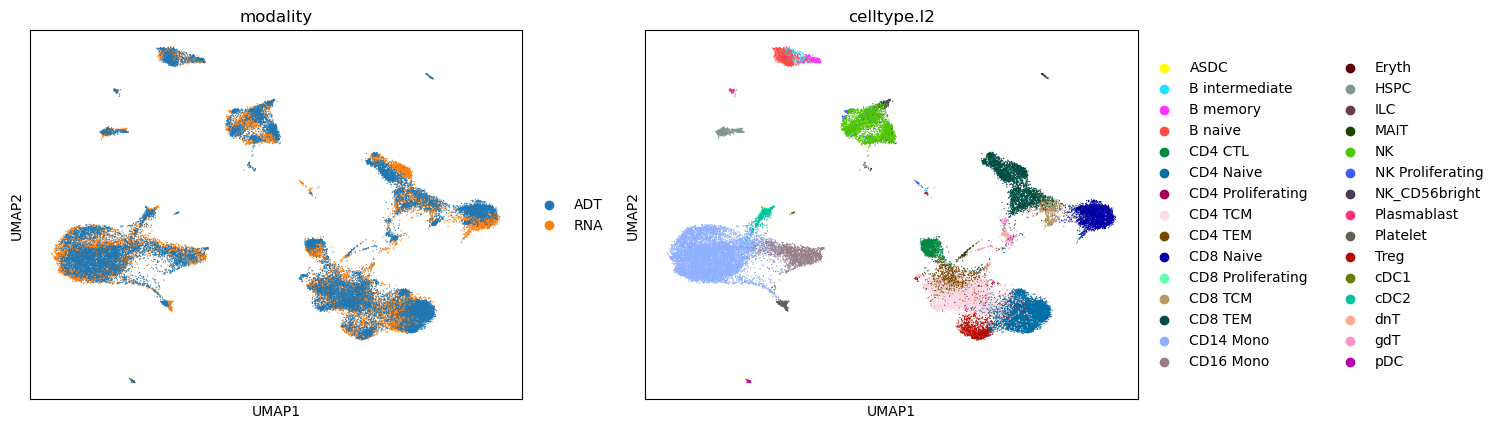

In [10]:
sc.pl.umap(adata_integrated, color=['modality', 'celltype.l2'])

## Evaluation

In [11]:
from scipy.spatial.distance import cdist

dist_mtx = cdist(model.latent[adata1.shape[0]:, :], 
                 model.latent[:adata1.shape[0], :], 
                 metric='euclidean') # Transfer labels from RNA to ADT

matching = dist_mtx.argsort()[:, :1]

df1_labels = adata_RNA.obs["celltype.l1"].values
df2_labels = adata_ADT.obs["celltype.l1"].values

print("Label transfer accuracy: ", np.sum(df1_labels == df2_labels[matching.reshape(-1)]) / adata_RNA.shape[0])

Label transfer accuracy:  0.9782078296550959


## Feature imputation

In this example, we show the utility of scMODAL to impute protein abundance levels based on gene expressions.

In [12]:
# get imputed features in DataFrame
model.get_imputed_df()
imputed_df = model.imputed_df_AtoB

# get ground truth for comparison
true_df = pd.DataFrame(adata2.X[:, :RNA_shared.shape[1]], index=adata2.obs.index, columns=adata2.var.feature_name[:RNA_shared.shape[1]])
true_df = true_df.groupby(true_df.columns, axis=1).mean()

In [17]:
adata_imputed = ad.AnnData(X=np.concatenate([imputed_df.values, true_df.values], axis=1))
adata_imputed.obs = adata_RNA.obs
adata_imputed.var.index = list(imputed_df.columns + '_imputed') + list(true_df.columns)
adata_imputed.obsm['X_umap'] = adata_integrated.obsm['X_umap'][:adata_RNA.shape[0]]

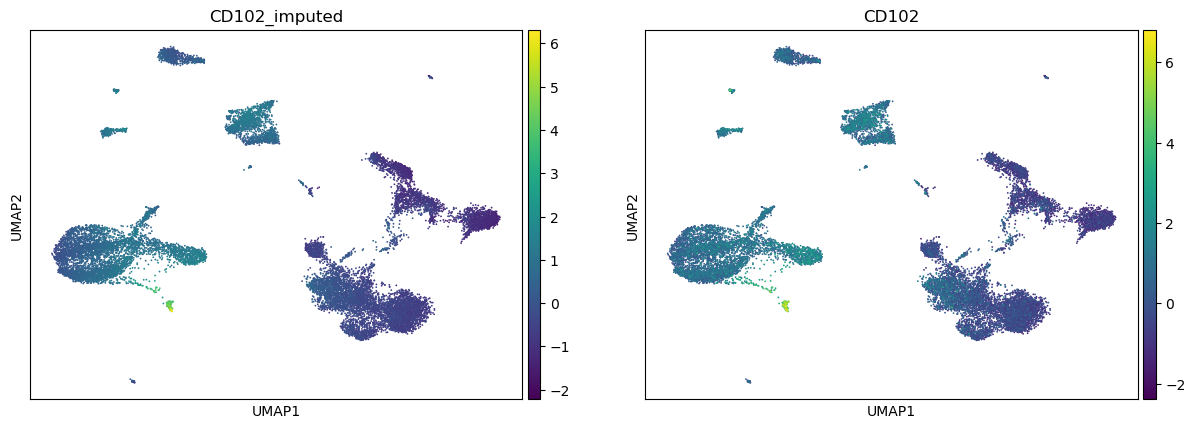

In [18]:
# plot imputed protein abundance levels vs ground truth
sc.pl.umap(adata_imputed, color=['CD102_imputed', 'CD102'])